## Can film be clustered by their emotional tone? And do these cluster reveal distinct patterns in consumer ratings?

In [1]:
import pandas as pd
import numpy as np 
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from utils.methods import *

df = pd.read_csv('../../data/final_data_complete.csv')

temp = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))

emotions_df = pd.concat([df, temp], axis=1)
assert emotions_df["distilbert_emotions"].isna().sum() == emotions_df["Plot"].isna().sum()

In [2]:
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']
ratings = ['mean_ratings', 'std_dev_ratings']


filter_df = emotions_df.dropna(subset=['Plot'])
final_df = filter_df[emotions + ratings].reset_index(drop=True)
final_df.head()

,disgust,fear,anger,neutral,sadness,surprise,joy,mean_ratings,std_dev_ratings
0,0.502122,0.351022,0.065147,0.057085,0.018771,0.004086,0.001766,2.427083,1.087064
1,0.324022,0.032032,0.502404,0.096385,0.037811,0.005438,0.001907,2.250000,2.474874
2,0.163747,0.002405,0.325650,0.440068,0.025255,0.005851,0.037024,NaN,NaN
3,0.021709,0.010488,0.006082,0.042634,0.915504,0.002163,0.001421,NaN,NaN
4,0.004746,0.003841,0.016094,0.679410,0.057925,0.129912,0.108072,4.140052,0.835965


#### The data are already on the same scale and sum to 1 representing proportions of the emotional tone of the film so there is no need to normalize them. 

#### We start from doing some exploration of the data.

(33684, 9)
(235788, 2)


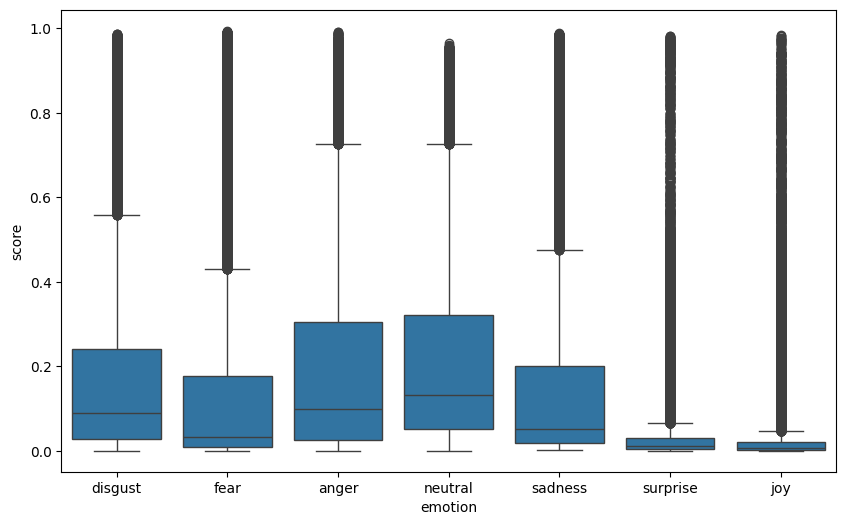

In [3]:
print(final_df.shape)

long_df = pd.melt(final_df[emotions], var_name='emotion', value_name='score')
print(long_df.shape)

plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='score', data=long_df)
plt.show()

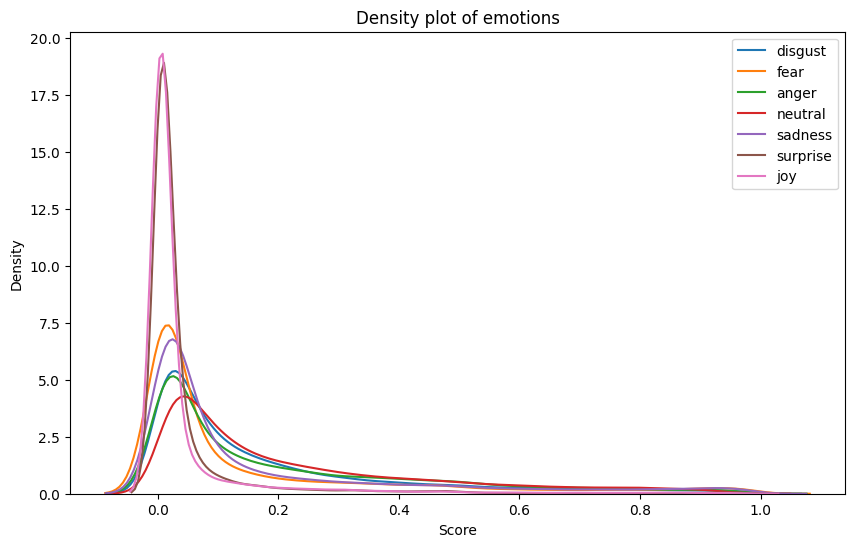

In [4]:
plt.figure(figsize=(10, 6))
for emotion in final_df[emotions].columns:
    sns.kdeplot(final_df[emotion], label=emotion, fill=False)
plt.xlabel('Score')
plt.legend()
plt.title('Density plot of emotions')
plt.show()


#### To start, we perform a Hierchical Clustering o the data and plot the dendrogram to see if there are any clear clusters.

#### We will perform Hierchical Clustering with average linkage and Cosine distance. The Cosine distance is chosen because it is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Thats works particularly well when the data are in distributed in a simplex like in this case.

#### Since Hierchical Clustiering computes dinstances between all pairs of points, it scales poorly with large dataset like ours. To have and understandig of the possible clusters we will use a subset of 500 data points.

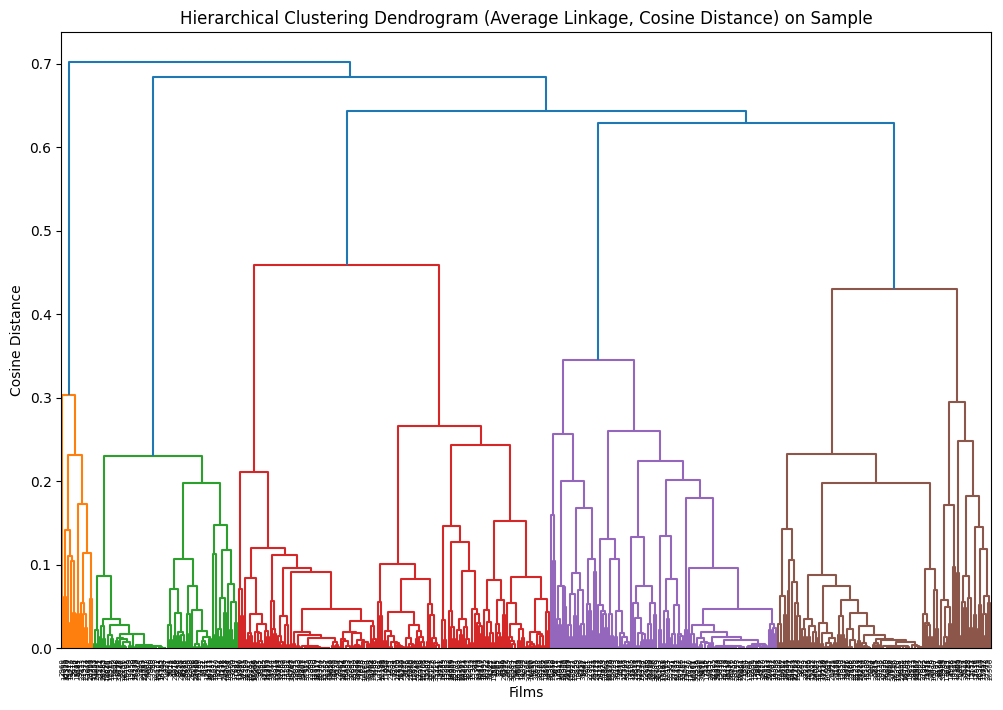

In [5]:
#Perform Hierarchical Clustering with average linkage and cosine distance, no normalization
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

sample_df = final_df.sample(500, random_state=42)

cluster_df = sample_df[emotions].copy()

distance_matrix = pdist(cluster_df, metric='cosine')
linkage_matrix = linkage(distance_matrix, method='average')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=cluster_df.index, orientation='top')
plt.title('Hierarchical Clustering Dendrogram (Average Linkage, Cosine Distance) on Sample')
plt.xlabel('Films')
plt.ylabel('Cosine Distance')
plt.show()


In [6]:
cutoff = 0.36

cluster_labels = fcluster(linkage_matrix, t = cutoff, criterion='distance')
cluster_df['cluster'] = cluster_labels


distance_square = squareform(distance_matrix)

def compute_inner_cluster_distances(labels, distances):
    unique_clusters = np.unique(labels)
    inner_distances = {}
    for cluster in unique_clusters:
        indices = np.where(labels == cluster)[0]
        if len(indices) > 1:
            intra_dist = distances[np.ix_(indices, indices)].mean()
        else:
            intra_dist = 0  # Single-point cluster
        inner_distances[cluster] = intra_dist
    return inner_distances

inner_cluster_distances = compute_inner_cluster_distances(cluster_labels, distance_square)
inner_cluster_distances



{1: 0.17915203395297508,
 2: 0.1548717409338018,
 3: 0.08524913979233686,
 4: 0.19856307786260435,
 5: 0.22647867626450144,
 6: 0.12105150467831619,
 7: 0.20818028729421426}

In [14]:
sample_df = pd.concat([cluster_df, sample_df[ratings]], axis=1)
cluster_summary = sample_df.groupby('cluster').mean()
cluster_summary

,disgust,fear,anger,neutral,sadness,surprise,joy,mean_ratings,std_dev_ratings
cluster,,,,,,,,,
1,0.109742,0.064062,0.089342,0.134547,0.073385,0.504592,0.024330,2.869160,0.997983
2,0.095067,0.593484,0.150145,0.097640,0.034013,0.021828,0.007823,2.792405,0.910411
3,0.097704,0.051368,0.646144,0.103608,0.058588,0.019774,0.022814,2.943252,0.997451
4,0.474915,0.039981,0.229493,0.157039,0.073580,0.010769,0.014224,3.106239,0.966592
5,0.098432,0.081701,0.098737,0.138472,0.529758,0.027796,0.025103,3.079460,1.061549
6,0.066829,0.063999,0.076389,0.636251,0.056975,0.040132,0.059425,3.022045,1.059960
7,0.080505,0.016390,0.058520,0.267902,0.117829,0.053301,0.405553,2.664684,1.026668


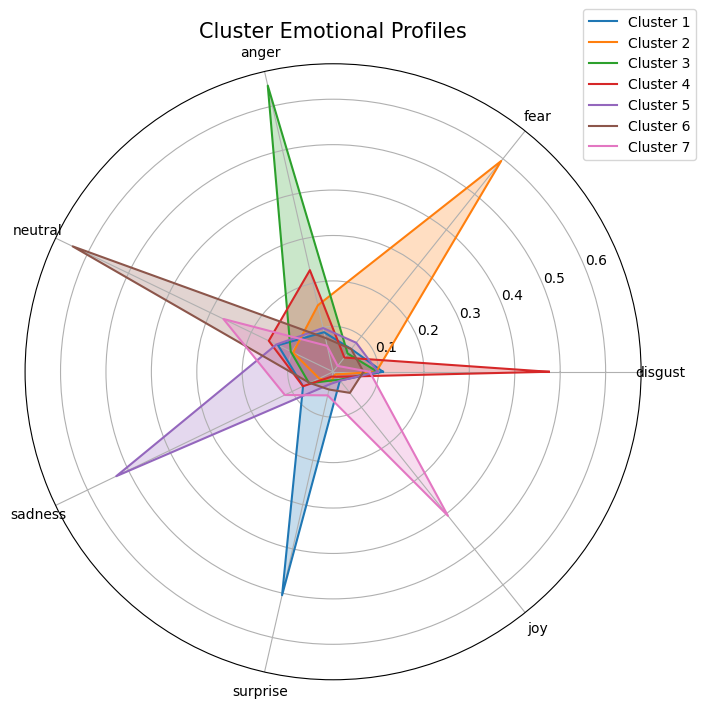

In [16]:
def plot_radar_chart(data, title):
    categories = data.columns
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, row in data.iterrows():
        values = row.tolist() + row.tolist()[:1]
        ax.plot(angles, values, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)
        
    ax.set_title(title, size=15)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()

plot_radar_chart(cluster_summary[emotions], "Cluster Emotional Profiles")

